In [29]:
import os
os.chdir(r'C:\Users\Administrator\LYC\SARMA\SARMA_code_share')

from main.BCD_LS import *
from main.BCD_MLE import *
from main.tensorOp import * 
from main.IOLS_VARMA import *
import main.help_function_for_LS as lsfunc
import main.help_function_for_MLE as mlfunc
from main.MACM import *
from main.BIC import *
from main.forecast import *

import pandas as pd
import numpy as np
from tqdm import tqdm


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec


In [7]:
# import data
df = pd.read_csv("Application//FREDMD.csv",header=0, index_col=0)
df=df[['RPI','INDPRO','UNRATE','M2SL','CPIAUCSL','DPCERA3M086SBEA']]
df = df.drop(df.index[0])
df.index = pd.to_datetime(df.index)
df.head(5)
null_columns=df.isnull().any()

df = df[:-4]

# seasonally and stationally adjusted
df['RPI'] = df['RPI'].diff()
df['INDPRO'] = np.log(df['INDPRO']).diff()
df['UNRATE'] = np.log(df['UNRATE']).diff()
df['M2SL'] = np.log(df['M2SL']).diff().diff()
df['CPIAUCSL'] = np.log(df['CPIAUCSL']).diff().diff()
df['DPCERA3M086SBEA'] = np.log(df['DPCERA3M086SBEA']).diff()
df.dropna(inplace=True)

In [8]:
# standardized
df_norm = (df-df.mean())/df.std()

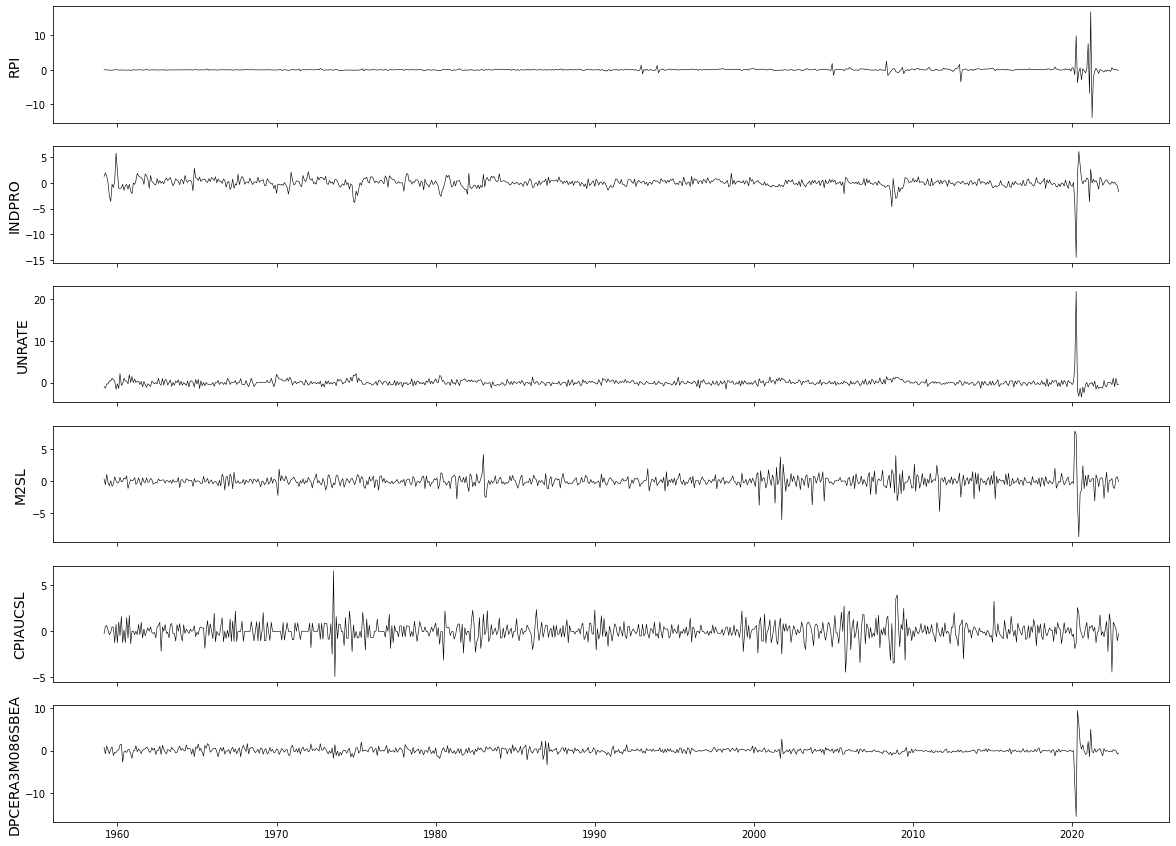

In [9]:
T,N = df_norm.shape
# plot
fig, axes = plt.subplots(nrows=N, ncols=1, sharex=True, figsize=(20, 15))
for idx, col in enumerate(df.columns):
    axes[idx].plot(df_norm[col],color='black',lw=0.6)
    axes[idx].set_ylabel(col,fontsize=14)
plt.show()


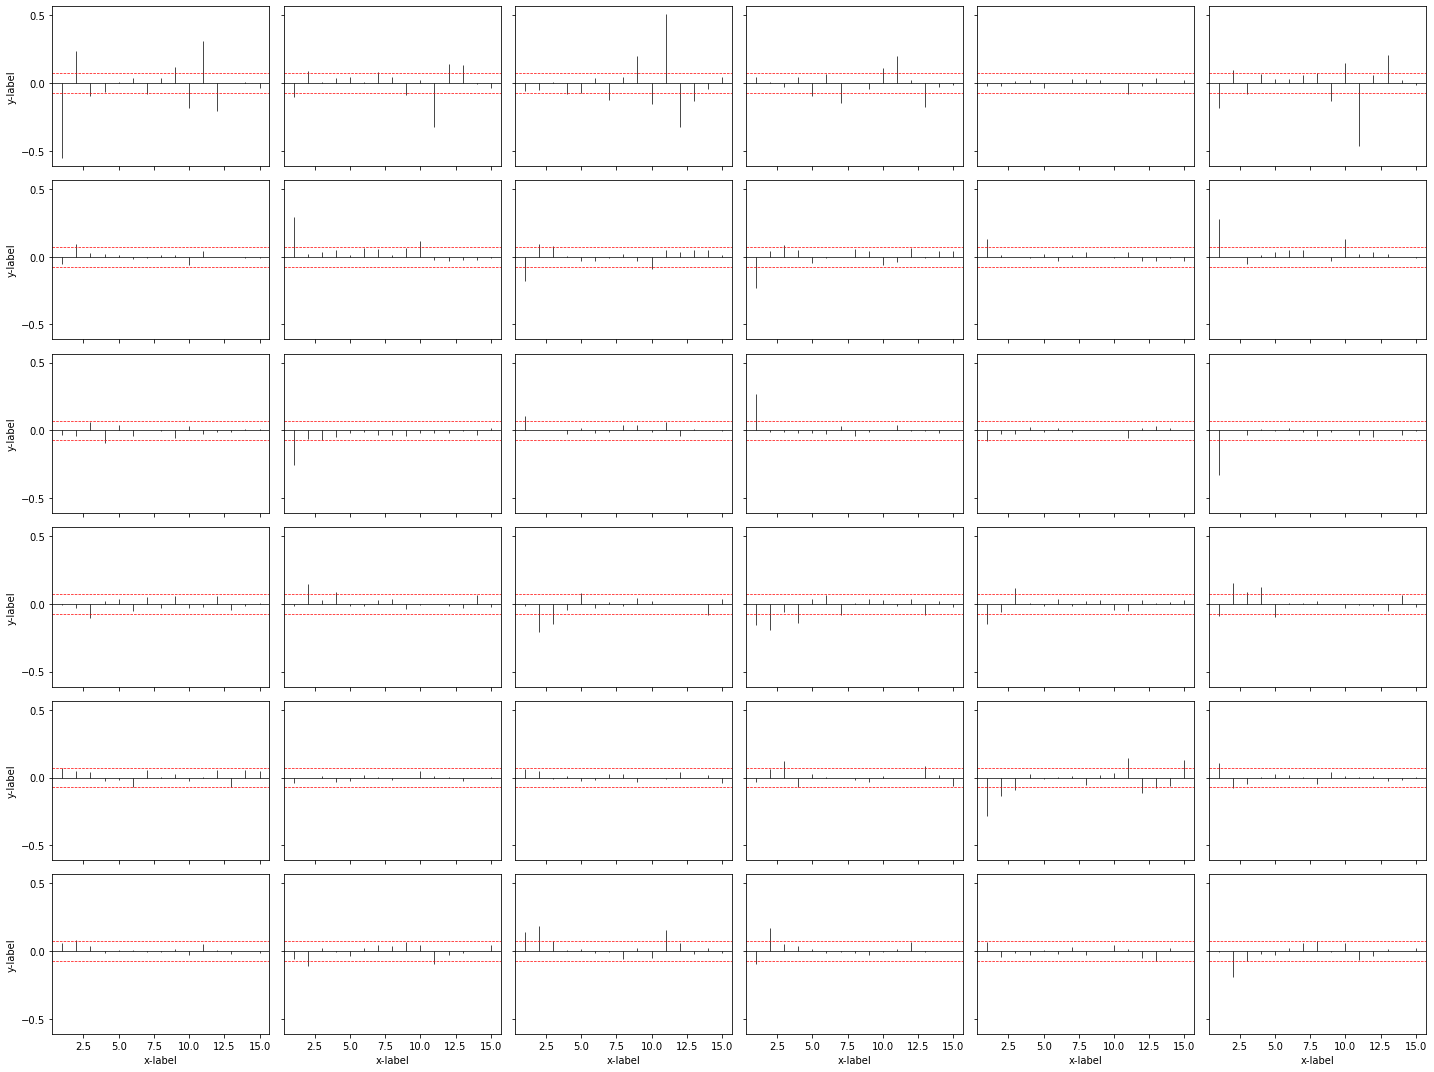

In [10]:

MACM_y=MACM(df_norm.values,15)
lag=16
err_bound = 2 / np.sqrt(T)
xlabel_lags=np.arange(1,lag)

fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(20, 15), sharex='all', sharey='all')
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.vlines(xlabel_lags, [0], MACM_y[:,i,j] ,color='k',linewidth=0.7)
        ax.axhline(0, color='k',linewidth=0.7)
        ax.axhline(err_bound, color='r', linestyle='--',linewidth=0.7)
        ax.axhline(-err_bound, color='r', linestyle='--',linewidth=0.7)
        if i == 5: 
            ax.set_xlabel('x-label')
            # axs[i, j].set_xticks([-0.5, 0, 0.5])
        if j == 0:  
            ax.set_ylabel('y-label')
            ax.set_yticks(np.linspace(-0.5,0.5,3))
plt.tight_layout()
plt.savefig("MACM_realdate.png", bbox_inches='tight')
plt.show()

In [11]:
df=df_norm.values.T
N,T = df.shape
p_m =2; r_m = 2; s_m = 1
# BIC choose order
BIC_reuslt = BIC(df,p_m,r_m ,s_m )

In [10]:
BIC_reuslt['ML_BIC_table']

BIC                   initial
p r s                                    
0 0 0  5.992167                       NaN
    1 -2.371923                (0.8, 0.5)
  1 0 -2.372971                  (0.267,)
    1 -2.298148        (-0.267, 0.6, 0.5)
  2 0  -2.44329              (0.267, 0.8)
    1 -2.177716    (0.267, 0.8, 0.8, 0.5)
1 0 0 -2.048825                       NaN
    1 -2.302708                (0.4, 0.5)
  1 0 -2.444593                  (0.267,)
    1 -2.199323           (0.8, 0.8, 0.5)
  2 0 -2.344784              (0.8, 0.267)
    1 -1.981751  (0.8, 0.267, 0.8, 2.742)
2 0 0 -2.050055                       NaN
    1 -2.075352                (0.6, 0.5)
  1 0 -2.211167                  (0.267,)
    1 -1.977295         (0.8, 0.8, 1.994)
  2 0 -2.120762              (0.8, 0.267)
    1  -1.74342   (0.8, -0.8, 0.6, 1.247)

In [12]:
# selected order
p=0; r=1; s=0

In [13]:
# LS estimation
P=20; n_iter=50
lmbd=[0.95];gamma=[];phi=[]
result_LS = BCD_LS(df,p,r,s,P,n_iter,lmbd=np.array(lmbd), gamma = np.array(gamma), phi = np.array(phi),stop_thres=1e-5,result_show=True)
LS_lmbd,LS_eta,LS_G,LS_A,LS_Sigma=result_LS[['lmbd','eta','G','A','Sigma']]
LS_gamma,LS_phi = LS_eta

 Stop for reach SepEst limitation Order: (0, 1, 0); No. of iter: 21 
 omega_diff: 0.00016947755688212496; G_diff: 0.0005592540344018584; Sigma_diff: 8.956492425914522e-05
 Final Loss: 4.881173366562337
 Param: lmbd: [0.70564751],
 gamma: [],
 phi: [],
 G: [[[-0.93421497]
  [ 0.04583305]
  [-0.09995786]
  [ 0.17381431]
  [-0.05192259]
  [-0.22988753]]

 [[ 0.06407295]
  [ 0.21805185]
  [ 0.29004904]
  [-0.07741474]
  [ 0.17088647]
  [ 0.26138386]]

 [[-0.16884898]
  [-0.17261226]
  [-0.29807251]
  [ 0.23875349]
  [-0.09471871]
  [-0.32418293]]

 [[ 0.04245902]
  [-0.05199571]
  [-0.17104137]
  [-0.61184903]
  [-0.3158753 ]
  [-0.20919506]]

 [[ 0.15233262]
  [ 0.01115532]
  [ 0.1069712 ]
  [-0.02515672]
  [-0.75680172]
  [ 0.19817795]]

 [[ 0.17807553]
  [ 0.14386027]
  [ 0.26265611]
  [-0.04173493]
  [ 0.06480006]
  [-0.08700576]]], 
 Sigma: [[ 0.66956181  0.00962714  0.16027481  0.1185497  -0.01927856  0.01005853]
 [ 0.00962714  0.88009702 -0.50067684 -0.27684963  0.07636842  0.529626

In [16]:
y=df
Y = y[:,1:]
x = (np.flip(y,axis=1)).ravel(order='F') # N(T-1) array: vectorized from y_T to y_1
X1 = np.zeros((N*(T-1),T-1))
for i in range(T-1):
    X1[:(i+1)*N,i] = x[-(i+1)*N:]
X2 = np.zeros((T-1,N,T-p-1)) #  shape: (T-1)*N*(T-p-1)  
for i in range(p,T-1):
    X2[i,:,:(i+1-p)] = np.flip(y[:,:i+1-p],axis=1)
L = get_L(LS_lmbd,LS_eta,r,s,T,p) # L: T*d matrix
z = kron([L[:T-1,:].T,np.identity(N)]) @ X1
epsilon = Y-tensor_op.unfold(LS_A[:,:,:T-1],0).numpy() @ X1


Sigma_inv = np.linalg.inv(LS_Sigma)
ASD_LS = np.sqrt(np.diag(lsfunc.asymptotic(LS_lmbd,LS_eta,LS_G,LS_Sigma,z,X2,epsilon,p,r,s,N,T))).round(3)
ASD_LS_G = ASD_LS[1:].reshape((6,6),order='F')

LS_Sigma.round(3)
vech_sigma_deva=0
for i in range(T-1):
    de_cen = (np.outer(epsilon[:,i], epsilon[:,i])-LS_Sigma)[np.triu_indices(N)]
    vech_sigma_deva += np.outer(de_cen,de_cen)/(T-1)
ASD_LS_Sigma= np.zeros((6,6))
N=6
ASD_LS_Sigma[np.triu_indices(N)]=np.sqrt(np.diag(vech_sigma_deva)/(T-1)).round(3)

In [35]:
# QML estimation

lmbd=[0.95];gamma=[];phi=[]
result_ML = BCD_MLE(df,p,r,s,P,n_iter,lmbd=np.array(lmbd), gamma = np.array(gamma), phi = np.array(phi),stop_thres=1e-5,result_show=True)
ML_lmbd,ML_eta,ML_G,ML_A,ML_Sigma=result_ML[['lmbd','eta','G','A','Sigma']]
ML_gamma,ML_phi = ML_eta

 Stop for reach SepEst limitation Order: (0, 1, 0); No. of iter: 12 
 omega_diff: 0.00010147622988321281; G_diff: 0.00033424354046133337; Sigma_diff: 5.449103536940385e-05
 Final Loss: -2.6937816667867462
 Param: lmbd: [0.70832189],
 gamma: [],
 phi: [],
 G: [[[-0.92918942]
  [ 0.04617475]
  [-0.09909886]
  [ 0.17375004]
  [-0.05150489]
  [-0.22777838]]

 [[ 0.0641578 ]
  [ 0.2159319 ]
  [ 0.28831281]
  [-0.07670036]
  [ 0.17030847]
  [ 0.26006784]]

 [[-0.16873154]
  [-0.17075132]
  [-0.29572326]
  [ 0.23812047]
  [-0.09442694]
  [-0.32163262]]

 [[ 0.04228724]
  [-0.05135281]
  [-0.16890678]
  [-0.61041606]
  [-0.31482227]
  [-0.20685233]]

 [[ 0.15196381]
  [ 0.01120344]
  [ 0.10559211]
  [-0.02536301]
  [-0.75529456]
  [ 0.19625345]]

 [[ 0.17781147]
  [ 0.14324581]
  [ 0.26053439]
  [-0.04048095]
  [ 0.06426254]
  [-0.08680006]]], 
 Sigma: [[ 0.67033125  0.00953584  0.16046048  0.11874723 -0.01944918  0.01006808]
 [ 0.00953584  0.88018402 -0.50087592 -0.27687015  0.07648821  0.529

In [23]:
y=df
Y = y[:,1:]
x = (np.flip(y,axis=1)).ravel(order='F') # N(T-1) array: vectorized from y_T to y_1
X1 = np.zeros((N*(T-1),T-1))
for i in range(T-1):
    X1[:(i+1)*N,i] = x[-(i+1)*N:]
X2 = np.zeros((T-1,N,T-p-1)) #  shape: (T-1)*N*(T-p-1)  
for i in range(p,T-1):
    X2[i,:,:(i+1-p)] = np.flip(y[:,:i+1-p],axis=1)
L = get_L(ML_lmbd,ML_eta,r,s,T,p) # L: T*d matrix
z = kron([L[:T-1,:].T,np.identity(N)]) @ X1
epsilon = Y-tensor_op.unfold(ML_A[:,:,:T-1],0).numpy() @ X1
Sigma_inv = np.linalg.inv(ML_Sigma)

ASD_ML = np.sqrt(np.diag(mlfunc.asymptotic(ML_lmbd,ML_eta,ML_G,Sigma_inv,z,X2,epsilon,p,r,s,N,T))).round(3)
ASD_ML_G = ASD_ML[1:-21].reshape((6,6),order='F')

vech_sigma_deva=0
for i in range(T-1):
    de_cen = (np.outer(epsilon[:,i], epsilon[:,i])-ML_Sigma)[np.triu_indices(N)]
    vech_sigma_deva += np.outer(de_cen,de_cen)/(T-1)
ASD_MLE_Sigma= np.zeros((6,6))
N=6
ASD_MLE_Sigma[np.triu_indices(N)]=np.sqrt(np.diag(vech_sigma_deva)/(T-1)).round(3)

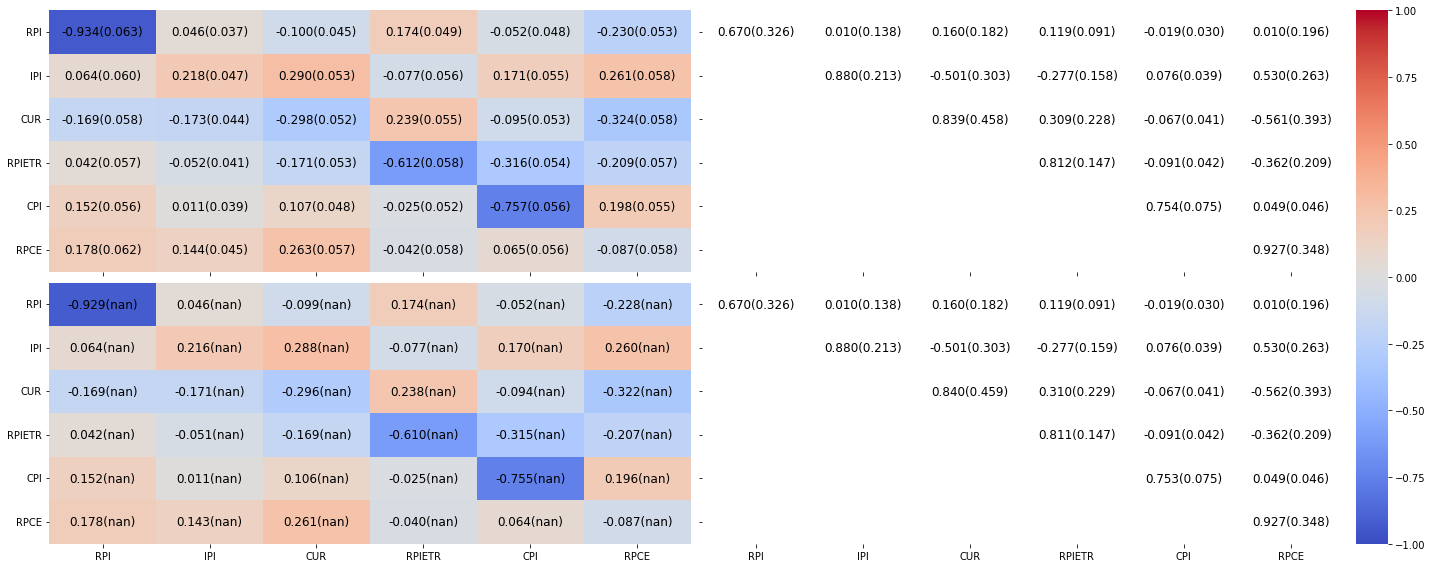

In [25]:

ASD_MLE_Sigma[np.tril_indices_from(ASD_MLE_Sigma, k=-1)] = np.nan 
ASD_LS_Sigma[np.tril_indices_from(ASD_LS_Sigma, k=-1)] = np.nan 
ML_Sigma[np.tril_indices_from(ML_Sigma, k=-1)] = np.nan 
LS_Sigma[np.tril_indices_from(LS_Sigma, k=-1)] = np.nan 

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 0.05])  
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[3])
ax3 = plt.subplot(gs[4])
cax = plt.subplot(gs[:, 2])
index = ['RPI','IPI','CUR','RPIETR','CPI','RPCE']  # index name


# first heatmap 
sns.heatmap(LS_G[:, :, 0].round(3), fmt=".3f", cmap='coolwarm', ax=ax0, vmin=-1, vmax=1, cbar_ax=cax)
for i in range(LS_G.shape[0]):
    for j in range(LS_G.shape[1]):
        text = f"{LS_G[i, j, 0]:.3f}({ASD_LS_G[i, j]:.3f})"
        ax0.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=12)
# ax0.set_xticklabels(index, rotation=0)  
ax0.set_xticklabels([])
ax0.set_yticklabels(index, rotation=0)  

# second heatmap
# sns.heatmap(LS_Sigma.round(3), fmt=".3f", cmap='coolwarm', ax=ax1, vmin=-1, vmax=1, cbar_ax=cax)
sns.heatmap(np.full((N,N),np.nan), fmt=".3f", cmap='coolwarm', ax=ax1, vmin=-1, vmax=1, cbar_ax=cax)
for i in range(LS_Sigma.shape[0]):
    for j in range(LS_Sigma.shape[1]):
        if i <= j:
            text = f"{LS_Sigma[i, j]:.3f}({ASD_LS_Sigma[i, j]:.3f})"
            ax1.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=12)
# ax1.set_xticklabels(index, rotation=0)  
# ax1.set_yticklabels(index, rotation=0)  
ax1.set_xticklabels([])
ax1.set_yticklabels([])

# third heatmap
# ax2 = fig.add_subplot(gs[1])
sns.heatmap(ML_G[:, :, 0].round(3), fmt=".3f", cmap='coolwarm', ax=ax2, vmin=-1, vmax=1, cbar=False)
for i in range(ML_G.shape[0]):
    for j in range(ML_G.shape[1]):
        text = f"{ML_G[i, j, 0]:.3f}({ASD_ML_G[i, j]:.3f})"
        ax2.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=12)
ax2.set_xticklabels(index, rotation=0) 
ax2.set_yticklabels(index, rotation=0)  

# fourth heatmap
# sns.heatmap(ML_Sigma.round(3), fmt=".3f", cmap='coolwarm', ax=ax3, vmin=-1, vmax=1, cbar_ax=cax)
sns.heatmap(np.full((N,N),np.nan), fmt=".3f", cmap='coolwarm', ax=ax3, vmin=-1, vmax=1, cbar_ax=cax)
for i in range(ML_Sigma.shape[0]):
    for j in range(ML_Sigma.shape[1]):
        if i <= j:
            text = f"{ML_Sigma[i, j]:.3f}({ASD_MLE_Sigma[i, j]:.3f})"
            ax3.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=12)
ax3.set_xticklabels(index, rotation=0)  
# ax3.set_yticklabels(index, rotation=0)  
ax3.set_yticklabels([])
plt.tight_layout()
plt.savefig("realdata_coef.png", bbox_inches='tight')
plt.show()


In [30]:
# forecast function for SARMA

def for_SARMA(y_train, y_test, lmbd,gamma,phi, G, h=1,estimation = "LS", method = 'rolling'):
    '''
    h: h-step forecast;
    method: rolling--fix window;
            recursive--fix start point
    -----------------------------------
    output:
    N*[length(y_test)-h+1]
    '''
    N,T_train = y_train.shape
    T_test = y_test.shape[1]
    y_oos = np.zeros((N,T_test-h+1)) ## save forecasts

    for t in range(T_test-h+1):
        if method == "rolling":
            y = np.hstack((y_train[:,t:], y_test[:,:t])) 
        elif method  == "recursive":
            y = np.hstack((y_train[:,:], y_test[:,:t])) 
        if estimation == "LSE":
            fit = BCD_LS(y,p,r,s,P,n_iter,lmbd=np.array(lmbd), gamma = np.array([gamma]), phi = np.array([phi]),G = G,result_show=False)
        if estimation == "MLE":
            fit = BCD_MLE(y,p,r,s,P,n_iter,lmbd=np.array(lmbd), gamma = np.array([gamma]), phi = np.array([phi]),G = G,result_show=False)
        lmbd = fit['lmbd']
        gamma,phi = fit['eta']
        G = fit['G']
        y_oos[:,t] = forecast_SARMA(y,p,r,s,lmbd,gamma,phi, G, h=h)[:,-1]
        
    return y_oos

In [31]:
# forecast function for VAR_LS

def for_VAR(y_train, y_test ,h=1,order= (1,1), method = 'rolling'):
    N,T_train = y_train.shape
    T_test = y_test.shape[1]
    y_oos = np.zeros((N,T_test-h+1)) ## save forecasts

    for t in range(T_test-h+1):
        if method == "rolling":
            y = np.hstack((y_train[:,t:], y_test[:,:t])) 
        elif method  == "recursive":
            y = np.hstack((y_train[:,:], y_test[:,:t])) 
        model = VAR(y.T)
        results = model.fit(2)
        y_oos[:,t]= results.forecast(y.T[-2:],steps=1)
    return y_oos



In [32]:
# forecast function for VARMA_IOLS

def for_IOLS_VARMA(y_train, y_test ,h=1, method = 'rolling'):
    N,T_train = y_train.shape
    T_test = y_test.shape[1]
    y_oos = np.zeros((N,T_test-h+1)) ## save forecasts

    for t in range(T_test-h+1):
        if method == "rolling":
            y = np.hstack((y_train[:,t:], y_test[:,:t])) 
        elif method  == "recursive":
            y = np.hstack((y_train[:,:], y_test[:,:t])) 
        y_oos[:,t]= IOLS_pre(y).ravel('F')
    return y_oos

In [33]:
# forecast function for VARMA_QMLE
def for_VARMA(y_train, y_test ,h=1,order= (1,1), method = 'rolling'):
    N,T_train = y_train.shape
    T_test = y_test.shape[1]
    y_oos = np.zeros((N,T_test-h+1)) ## save forecasts

    for t in range(T_test-h+1):
        if method == "rolling":
            y = np.hstack((y_train[:,t:], y_test[:,:t])) 
        elif method  == "recursive":
            y = np.hstack((y_train[:,:], y_test[:,:t])) 
        model = VARMAX(y.T, order=(1,1))
        results = model.fit(maxiter= 20, disp=True)
        y_oos[:,t]= results.forecast(steps=1)
    return y_oos


In [36]:
# forecasting setting
y_train =df[:,:600]
y_test=df[:,600:]
h=1 

# forecasst
forecast_SARMA_LS = for_SARMA(y_train, y_test, LS_lmbd,LS_gamma,LS_phi, LS_G, h=1,estimation = "LSE", method = 'rolling')
forecast_SARMA_QML = for_SARMA(y_train, y_test, ML_lmbd,ML_gamma,ML_phi, ML_G, h=1,estimation = "MLE", method = 'rolling')
forcast_VARMA_IOLS = for_IOLS_VARMA(y_train, y_test, h=1 ,method = 'rolling')
forecast_VAR_LS = for_VAR(y_train, y_test, h=1,order = (1,1) ,method = 'rolling')
forcast_VARMA_QML = for_VARMA(y_train, y_test, h=1,order = (1,1) ,method = 'rolling')

e:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
e:\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
e:\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:1

In [43]:
SFE_table = pd.DataFrame(columns = ['SARMA_LS', 'SARMA_QML','VAR_LS', 'VARMA_IOLS','VARMA_QML'])
SAE_table = pd.DataFrame(columns = ['SARMA_LS', 'SARMA_QML','VAR_LS', 'VARMA_IOLS','VARMA_QML'])

SFE_table['SARMA_LS']= np.linalg.norm(forecast_SARMA_LS-y_test,ord= 2,axis=0)**2
SFE_table['SARMA_QML']= np.linalg.norm(forecast_SARMA_QML-y_test,ord= 2,axis=0)**2
SFE_table['VAR_LS'] = np.linalg.norm(forecast_VAR_LS-y_test,ord= 2,axis=0)**2
SFE_table['VARMA_IOLS'] = np.linalg.norm(forcast_VARMA_IOLS- y_test,ord=2,axis=0)**2
SFE_table['VARMA_QML'] = np.linalg.norm(forcast_VARMA_QML-y_test,ord= 2,axis=0)**2


SAE_table['SARMA_LS']= np.linalg.norm(forecast_SARMA_LS-y_test,ord= 1,axis=0)
SAE_table['SARMA_QML']= np.linalg.norm(forecast_SARMA_QML-y_test,ord= 1,axis=0)
SAE_table['VAR_LS'] = np.linalg.norm(forecast_VAR_LS-y_test,ord= 1,axis=0)
SAE_table['VARMA_IOLS'] = np.linalg.norm(forcast_VARMA_IOLS- y_test,ord=1,axis=0)
SAE_table['VARMA_QML'] = np.linalg.norm(forcast_VARMA_QML-y_test,ord= 1,axis=0)

# rooted mean squared forecast error
RMSFE = np.sqrt(SFE_table.mean()).round(2)
print(f'RMSFE:\n{RMSFE}')
# mean absoluted forecast error
MAFE = SAE_table.mean().round(2)
print(f'MAFE:\n{MAFE}')

RMSFE:
SARMA_LS      4.77
SARMA_QML     4.67
VAR_LS        5.24
VARMA_IOLS    5.18
VARMA_QML     4.95
dtype: float64
MAFE:
SARMA_LS      4.61
SARMA_QML     4.56
VAR_LS        4.99
VARMA_IOLS    4.90
VARMA_QML     4.85
dtype: float64
